
# 数据清洗之推特数据



## 数据清洗（data cleaning）
是数据分析的重要步骤，其主要目标是将混杂的数据清洗为可以被直接分析的数据，一般需要将数据转化为数据框（data frame）的样式。

本章将以推特文本的清洗作为例子，介绍数据清洗的基本逻辑。

- 清洗错误行
- 正确分列
- 提取所要分析的内容
- 介绍通过按行、chunk的方式对大规模数据进行预处理




### 同时考虑分列符和引用符

- 分列符🔥分隔符：sep, delimiter
- 引用符☁️：quotechar


In [1]:
# 提示：你可能需要修改以下路径名
with open("./data/ows_tweets_sample.txt", 'r') as f:
    chunk = f.readlines()

In [2]:
len(chunk)

2754

In [3]:
import csv
lines_csv = csv.reader(chunk, delimiter=',', quotechar='"') 
print(len(list(lines_csv)))
# next(lines_csv)
# next(lines_csv)

2628


In [4]:
import pandas as pd
df = pd.read_csv("./data/ows_tweets_sample.txt",
                 sep = ',', quotechar='"')
df[:3]

,Twitter ID,Text,Profile Image URL,Day,Hour,Minute,Created At,Geo,From User,From User ID,Language,To User,To User ID,Source
0,121813144174727168,RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLIN...,http://a2.twimg.com/profile_images/1539375713/...,2011-10-06,5,4,2011-10-06 05:04:51,N;,Anonops_Cop,401240477,en,NaN,0,&lt;a href=&quot;http://twitter.com/&quot;&gt;...
1,121813146137657344,@jamiekilstein @allisonkilkenny Interesting in...,http://a2.twimg.com/profile_images/1574715503/...,2011-10-06,5,4,2011-10-06 05:04:51,N;,KittyHybrid,34532053,en,jamiekilstein,2149053,&lt;a href=&quot;http://twitter.com/&quot;&gt;...
2,121813150000619521,@Seductivpancake Right! Those guys have a vict...,http://a1.twimg.com/profile_images/1241412831/...,2011-10-06,5,4,2011-10-06 05:04:52,N;,nerdsherpa,95067344,en,Seductivpancake,19695580,&lt;a href=&quot;http://www.echofon.com/&quot;...


In [5]:
len(df) 

2627

In [6]:
#df.columns #
df['Text'][0]

'RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE RT !!HELP!!!!'

In [7]:
df['From User'][:10]

0       Anonops_Cop
1       KittyHybrid
2        nerdsherpa
3        hamudistan
4           kl_knox
5     vickycrampton
6    burgerbuilders
7          neverfox
8       davidgaliel
9           AnonOws
Name: From User, dtype: object

### 统计发帖数量所对应的人数的分布
> 人数在发帖数量方面的分布情况

In [8]:
from collections import defaultdict
data_dict = defaultdict(int)
for i in df['From User']:
    data_dict[i] +=1 

In [9]:
list(data_dict.items())[:5]
#data_dict

[('Anonops_Cop', 1),
 ('KittyHybrid', 1),
 ('nerdsherpa', 2),
 ('hamudistan', 1),
 ('kl_knox', 1)]

In [10]:
import pylab as plt

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号, 注意['SimHei']对应这句不行.

plt.style.use('ggplot') 

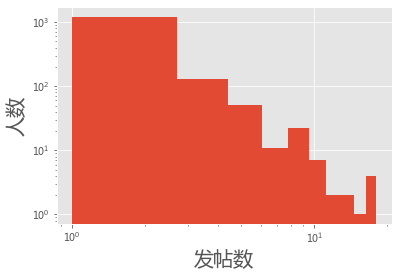

In [11]:
plt.hist(data_dict.values())
plt.yscale('log')
plt.xscale('log')
plt.xlabel(u'发帖数', fontsize = 20)
plt.ylabel(u'人数', fontsize = 20)
plt.show()

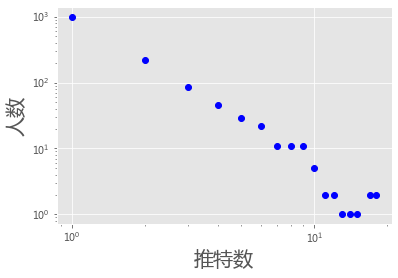

In [12]:
tweet_dict = defaultdict(int)
for i in data_dict.values():
    tweet_dict[i] += 1 
 
plt.loglog(list(tweet_dict.keys()), list(tweet_dict.values()), 'bo')#linewidth=2)  
plt.xlabel(u'推特数', fontsize=20)
plt.ylabel(u'人数', fontsize=20 ) 
plt.show()

In [13]:
import numpy as np
import statsmodels.api as sm

def powerPlot(d_value, d_freq, color, marker):
    d_freq = [i + 1 for i in d_freq]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, linestyle = '',\
             color = color, marker = marker)
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/2,max(d_prob)/10,
             r'$\beta$ = ' + str(round(beta,2)) +'\n' + r'$R^2$ = ' + str(round(r2, 2)), fontsize = 20)

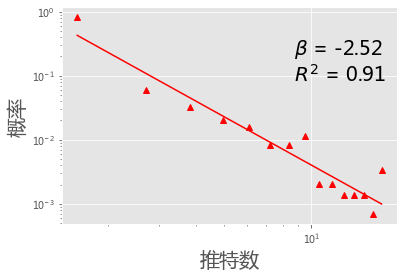

In [14]:
histo, bin_edges = np.histogram(list(data_dict.values()), 15)
bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])
powerPlot(bin_center,histo, 'r', '^')
#lg=plt.legend(labels = [u'Tweets', u'Fit'], loc=3, fontsize=20)
plt.ylabel(u'概率', fontsize=20)
plt.xlabel(u'推特数', fontsize=20) 
plt.show()

In [13]:
import statsmodels.api as sm
from collections import defaultdict
import numpy as np

def powerPlot2(data):
    d = sorted(data, reverse = True )
    d_table = defaultdict(int)
    for k in d:
        d_table[k] += 1
    d_value = sorted(d_table)
    d_value = [i+1 for i in d_value]
    d_freq = [d_table[i]+1 for i in d_value]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, 'ro')
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/2,max(d_prob)/5,
             'Beta = ' + str(round(beta,2)) +'\n' + 'R squared = ' + str(round(r2, 2)))
    plt.title('Distribution')
    plt.ylabel('P(K)')
    plt.xlabel('K')
    plt.show()
    

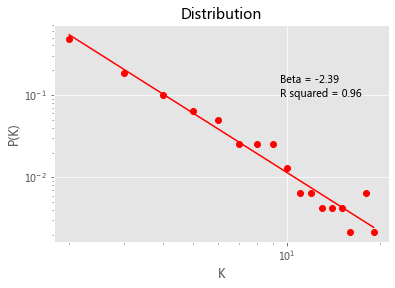

In [14]:
powerPlot2(data_dict.values())

In [38]:
pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-py3-none-any.whl size=24787 sha256=0e7d23e9100feb4fed1092e73633e496f9c1cb767c3f8632b9d9e9d488215eda
  Stored in directory: /Users/datalab/Library/Caches/pip/wheels/ee/51/38/2e0f20cf80e1a0909acdd527df2288bd9feb8356b926d7d775
Successfully built powerlaw
Note: you may need to restart the kernel to use updated packages.


In [15]:
import powerlaw
def plotPowerlaw(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=2)
    #fit = powerlaw.Fit(data)
    fit.plot_pdf(color = col, linewidth = 2)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    fit.power_law.plot_pdf(color = col, linestyle = 'dotted', ax = ax, \
                            label = r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x))
    ax.set_xlabel(xlab, fontsize = 20)
    ax.set_ylabel('$Probability$', fontsize = 20)
    plt.legend(loc = 0, frameon = False)

In [16]:
from collections import defaultdict
data_dict = defaultdict(int)

for i in df['From User']:
    data_dict[i] += 1

/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


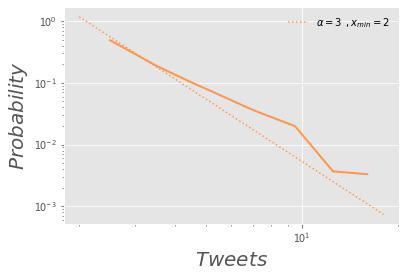

In [17]:
# 
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(6, 4),facecolor='white')
ax = fig.add_subplot(1, 1, 1)
plotPowerlaw(list(data_dict.values()), ax,cmap(1), 
             '$Tweets$')

## 清洗tweets文本

In [15]:
tweet = '''RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

In [16]:
#!pip install twitter-text
import re
import twitter_text 
# https://github.com/dryan/twitter-text-py/issues/21
#Macintosh HD ▸ 用户 ▸ datalab ▸ 应用程序 ▸ anaconda ▸ lib ▸ python3.5 ▸ site-packages

In [17]:
import re

tweet = '''RT @AnonKitsu: @who ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
rt_user_name = rt_patterns.findall(tweet)[0][1]#.strip(' @').split(':')[0]
rt_user_name 

' @AnonKitsu: @who'

In [18]:
import re

tweet = '''RT @AnonKitsu: @who ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", \
                         re.IGNORECASE)
rt_user_name = rt_patterns.findall(tweet)[0][1].strip(' @').split(':')[0]
rt_user_name

'AnonKitsu'

In [19]:
import re

tweet = '''@chengjun:@who ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
rt_user_name = rt_patterns.findall(tweet)
print(rt_user_name)

if rt_user_name:
    print('it exits.')
else:
    print('None')

[]
None


In [20]:
import re

def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_user_name = rt_patterns.findall(tweet)
    if rt_user_name:
        rt_user_name = rt_user_name[0][1].strip(' @').split(':')[0]
    else:
        rt_user_name = None
    return rt_user_name

In [21]:
tweet = '''RT @chengjun: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

extract_rt_user(tweet)    

'chengjun'

In [22]:
tweet = '''@chengjun: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

print(extract_rt_user(tweet) )

None


In [23]:
import csv

with open("./data/ows_tweets_sample.txt", 'r') as f:
    chunk = f.readlines()
    
rt_network = []
lines = csv.reader(chunk[1:], delimiter=',', quotechar='"')
tweet_user_data = [(i[1], i[8]) for i in lines]
tweet_user_data[:3]

[('RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE RT !!HELP!!!!',
  'Anonops_Cop'),
 ('@jamiekilstein @allisonkilkenny Interesting interview (never aired, wonder why??) by Fox with #ows protester http://t.co/Fte55Kh7',
  'KittyHybrid'),
 ("@Seductivpancake Right! Those guys have a victory condition: regime change. #ows doesn't seem to have a goal I can figure out.",
  'nerdsherpa')]

In [24]:
from collections import defaultdict

rt_network = []
rt_dict = defaultdict(int)
for k, i  in enumerate(tweet_user_data):
    tweet,user = i
    rt_user = extract_rt_user(tweet)
    if rt_user:
        rt_network.append((user, rt_user)) #(rt_user,'  ', user, end = '\n')
        rt_dict[(user, rt_user)] += 1
#rt_network[:5]
list(rt_dict.items())[:3]

[(('Anonops_Cop', 'AnonKitsu'), 1),
 (('hamudistan', 'bembel'), 1),
 (('vickycrampton', 'TheNewDeal'), 2)]

### 获得清洗过的推特文本

不含人名、url、各种符号（如RT @等）

In [25]:
def extract_tweet_text(tweet, at_names, urls):
    for i in at_names:
        tweet = tweet.replace(i, '')
    for j in urls:
        tweet = tweet.replace(j, '')
    marks = ['RT @', '@', '&quot;', '#', '\n', '\t', '  ']
    for k in marks:
        tweet = tweet.replace(k, '')
    return tweet

### 安装twitter_text

[twitter-text-py](https://github.com/dryan/twitter-text-py/issues/21) could not be used for python 3

Glyph debug the problem, and make [a new repo of twitter-text-py3](https://github.com/glyph/twitter-text-py).

>  pip install twitter-text


In [26]:
import twitter_text

tweet = '''RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili https://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

ex = twitter_text.Extractor(tweet)
at_names = ex.extract_mentioned_screen_names()
urls = ex.extract_urls()
hashtags = ex.extract_hashtags()
rt_user = extract_rt_user(tweet)
tweet_text = extract_tweet_text(tweet, at_names, urls)

print(at_names, urls, hashtags, rt_user,'-------->', tweet_text)

['AnonKitsu', 'chengjun', 'mili'] ['https://computational-communication.com', 'http://ccc.nju.edu.cn'] ['OCCUPYWALLSTREET', 'OWS', 'OCCUPYNY'] AnonKitsu --------> : ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! OCCUPYWALLSTREET OWS OCCUPYNY PLEASE RT !!HELP!!!!


In [27]:
import csv

lines = csv.reader(chunk,delimiter=',', quotechar='"')
tweets = [i[1] for i in lines] 

In [28]:
for tweet in tweets[:5]:
    ex = twitter_text.Extractor(tweet)
    at_names = ex.extract_mentioned_screen_names()
    urls = ex.extract_urls()
    hashtags = ex.extract_hashtags()
    rt_user = extract_rt_user(tweet)
    #tweet_text = extract_tweet_text(tweet, at_names, urls)

    print(at_names, urls, hashtags, rt_user)
    #print(tweet_text)

[] [] [] None
['AnonKitsu'] [] ['OCCUPYWALLSTREET', 'OWS', 'OCCUPYNY'] AnonKitsu
['jamiekilstein', 'allisonkilkenny'] ['http://t.co/Fte55Kh7'] ['ows'] None
['Seductivpancake'] [] ['ows'] None
['bembel'] ['http://j.mp/rhHavq'] ['OccupyWallStreet', 'OWS'] bembel


## 作业

提取出raw tweets中的rtuser与user的转发网络

格式：

rt_user1, user1, 3

rt_user2, user3, 2

rt_user2, user4, 1

...

数据保存为csv格式